In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from pathlib import Path
import random
from datetime import datetime
import neal  # D-Wave neal for simulated quantum annealing

BASE_PATH = "data"

class StockDataLoader:
    """
    Flexible data loader for the Kaggle stock market dataset.
    
    Dataset structure:
    - symbols_valid_meta.csv: metadata about valid tickers
    - Stocks/: directory containing individual ticker CSV files
    - ETFs/: directory containing ETF CSV files
    """
    
    def __init__(self, base_path):
        """
        Initialize the data loader.
        
        Parameters:
        -----------
        base_path : str
            Path to the base directory containing the dataset
        """
        self.base_path = Path(base_path)
        self.stocks_path = self.base_path / "Stocks"
        self.etfs_path = self.base_path / "ETFs"
        self.meta_path = self.base_path / "symbols_valid_meta.csv"
        
        # Load metadata if available
        if self.meta_path.exists():
            self.meta_data = pd.read_csv(self.meta_path)
        else:
            self.meta_data = None
            print("Warning: symbols_valid_meta.csv not found")
    
    def get_available_tickers(self, include_etfs=True):
        """
        Get list of all available tickers from the dataset.
        
        Parameters:
        -----------
        include_etfs : bool
            Whether to include ETF tickers
            
        Returns:
        --------
        list
            List of available ticker symbols
        """
        tickers = []
        
        # Get stock tickers
        if self.stocks_path.exists():
            stock_files = list(self.stocks_path.glob("*.csv"))
            tickers.extend([f.stem for f in stock_files])
        
        # Get ETF tickers
        if include_etfs and self.etfs_path.exists():
            etf_files = list(self.etfs_path.glob("*.csv"))
            tickers.extend([f.stem for f in etf_files])
        
        return sorted(tickers)
    
    def get_random_tickers(self, n=10, include_etfs=True, seed=None):
        """
        Generate a random list of ticker names.
        
        Parameters:
        -----------
        n : int
            Number of random tickers to select
        include_etfs : bool
            Whether to include ETF tickers
        seed : int, optional
            Random seed for reproducibility
            
        Returns:
        --------
        list
            List of randomly selected ticker symbols
        """
        if seed is not None:
            random.seed(seed)
        
        available_tickers = self.get_available_tickers(include_etfs)
        
        if n > len(available_tickers):
            print(f"Warning: Requested {n} tickers but only {len(available_tickers)} available")
            n = len(available_tickers)
        
        return random.sample(available_tickers, n)
    
    def get_date_range_summary(self, tickers):
        """
        Get summary of date ranges for specified tickers.
        
        Parameters:
        -----------
        tickers : list
            List of ticker symbols
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with min_date, max_date, and count for each ticker
        """
        summaries = []
        
        for ticker in tickers:
            df = self.load_ticker_data(ticker)
            if df is not None:
                df['Date'] = pd.to_datetime(df['Date'])
                summaries.append({
                    'Ticker': ticker,
                    'min_date': df['Date'].min(),
                    'max_date': df['Date'].max(),
                    'num_dates': len(df)
                })
        
        summary_df = pd.DataFrame(summaries)
        
        if not summary_df.empty:
            print("\n=== Date Range Summary ===")
            print(summary_df.to_string(index=False))
            print(f"\nCommon date range: {summary_df['min_date'].max()} to {summary_df['max_date'].min()}")
            
        return summary_df
    
    def load_ticker_data(self, ticker):
        """
        Load data for a single ticker.
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
            
        Returns:
        --------
        pd.DataFrame or None
            DataFrame with ticker data, or None if not found
        """
        # Try stocks directory first
        stock_file = self.stocks_path / f"{ticker}.csv"
        if stock_file.exists():
            df = pd.read_csv(stock_file)
            df['Ticker'] = ticker
            return df
        
        # Try ETFs directory
        etf_file = self.etfs_path / f"{ticker}.csv"
        if etf_file.exists():
            df = pd.read_csv(etf_file)
            df['Ticker'] = ticker
            return df
        
        print(f"Warning: Data for ticker {ticker} not found")
        return None
    
    def load_data(self, tickers=None, date_range='all', n_random=None, 
                  include_etfs=True, random_seed=None, filter_common_dates=True):
        """
        Load data for specified tickers and date range.
        
        Parameters:
        -----------
        tickers : list, optional
            List of ticker symbols to load. If None and n_random is specified,
            will load random tickers
        date_range : str or tuple
            Either 'all' for all dates, or tuple of (start_date, end_date) 
            in 'YYYY-MM-DD' format
        n_random : int, optional
            If specified and tickers is None, will load this many random tickers
        include_etfs : bool
            Whether to include ETFs when selecting random tickers
        random_seed : int, optional
            Random seed for reproducible random ticker selection
        filter_common_dates : bool, default=True
            If True, filters to only include dates where ALL tickers have data.
            This ensures uniform time series length across all tickers.
            
        Returns:
        --------
        pd.DataFrame
            Combined DataFrame with all ticker data
        """
        # Determine which tickers to load
        if tickers is None:
            if n_random is not None:
                tickers = self.get_random_tickers(n_random, include_etfs, random_seed)
                print(f"Randomly selected tickers: {tickers}")
            else:
                raise ValueError("Must specify either 'tickers' or 'n_random'")
        
        # Load data for each ticker
        all_data = []
        original_counts = {}
        
        for ticker in tickers:
            df = self.load_ticker_data(ticker)
            if df is not None:
                original_counts[ticker] = len(df)
                all_data.append(df)
        
        if not all_data:
            raise ValueError("No data loaded for any ticker")
        
        # Combine all data
        combined_data = pd.concat(all_data, ignore_index=True)
        combined_data['Date'] = pd.to_datetime(combined_data['Date'])
        
        # Filter by date range if specified
        if date_range != 'all':
            if isinstance(date_range, tuple) and len(date_range) == 2:
                start_date, end_date = date_range
                combined_data = combined_data[
                    (combined_data['Date'] >= start_date) & 
                    (combined_data['Date'] <= end_date)
                ]
                print(f"Filtered data to date range: {start_date} to {end_date}")
            else:
                raise ValueError("date_range must be 'all' or tuple of (start_date, end_date)")
        
        # Filter to common dates if requested
        if filter_common_dates:
            print("\n=== Filtering to common dates across all tickers ===")
            
            # Find dates that exist for ALL tickers
            date_counts = combined_data.groupby('Date')['Ticker'].nunique()
            n_tickers = combined_data['Ticker'].nunique()
            common_dates = date_counts[date_counts == n_tickers].index
            
            print(f"Total unique dates across all tickers: {len(date_counts)}")
            print(f"Dates with data for all {n_tickers} tickers: {len(common_dates)}")
            
            # Filter to only common dates
            combined_data_filtered = combined_data[combined_data['Date'].isin(common_dates)]
            
            # Report discarded rows for each ticker
            print("\nRows discarded per ticker:")
            for ticker in tickers:
                original = original_counts.get(ticker, 0)
                after_date_filter = len(combined_data[combined_data['Ticker'] == ticker])
                remaining = len(combined_data_filtered[combined_data_filtered['Ticker'] == ticker])
                discarded = after_date_filter - remaining
                
                print(f"  {ticker}: {discarded} rows discarded ({remaining} remaining out of {after_date_filter} after date filter)")
            
            total_before = len(combined_data)
            total_after = len(combined_data_filtered)
            print(f"\nTotal: {total_before - total_after} rows discarded ({total_after} remaining)")
            
            combined_data = combined_data_filtered
        
        # Sort by ticker and date for consistency
        combined_data = combined_data.sort_values(by=['Ticker', 'Date'])
        combined_data = combined_data.reset_index(drop=True)
        
        # Verify all tickers have the same number of dates
        dates_per_ticker = combined_data.groupby('Ticker')['Date'].count()
        if dates_per_ticker.nunique() > 1:
            print("\nWARNING: Tickers have different numbers of dates!")
            print(dates_per_ticker)
        else:
            print(f"\n✓ All {len(tickers)} tickers have {dates_per_ticker.iloc[0]} dates")
        
        return combined_data

def create_scatterplot(embeddings, labels, title):
    """
    Create a scatterplot with different color for each label.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Array of shape (2, n_samples) containing 2D embeddings
    labels : list
        List of labels for each sample
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    unique_labels = set(labels)
    colors = sns.color_palette("bright", len(unique_labels))
    
    for color, label in zip(colors, unique_labels):
        idx = [i for i, l in enumerate(labels) if l == label]
        # if embeddings has shape (2, n), we can index directly
        if embeddings.shape[0] == 2:
            x = embeddings[0, idx]
            y = embeddings[1, idx]
        elif embeddings.shape[1] == 2:
            x = embeddings[idx, 0]
            y = embeddings[idx, 1]
        elif embeddings.shape[0] == 1:
            x = embeddings[0, idx]
            y= 0
        elif embeddings.shape[1] == 1:
            x = embeddings[idx, 0]
            y = 0
        else:
            raise ValueError(f'{embeddings.shape} is weird')
        
        plt.scatter(x,y ,
                   color=color, label=label, s=100, alpha=0.6)
        
        # Add text annotations for each point
        for i in idx:
            plt.text(x + 0.0001, y, label, 
                    fontsize=9, alpha=0.7)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("PCA Component 1", fontsize=12)
    
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [2]:
DIVERSIFIED_50 = [
    # Technology (10)
    'AAPL',   # Apple - Consumer Electronics
    'MSFT',   # Microsoft - Software
    'GOOGL',  # Alphabet - Internet Services
    'NVDA',   # NVIDIA - Semiconductors
    'META',   # Meta - Social Media
    'ORCL',   # Oracle - Enterprise Software
    'INTC',   # Intel - Semiconductors
    'AMD',    # AMD - Semiconductors
    'CRM',    # Salesforce - Cloud Software
    'ADBE',   # Adobe - Software
    
    # Financial Services (8)
    'JPM',    # JPMorgan Chase - Banking
    'BAC',    # Bank of America - Banking
    'WFC',    # Wells Fargo - Banking
    'GS',     # Goldman Sachs - Investment Banking
    'MS',     # Morgan Stanley - Investment Banking
    'C',      # Citigroup - Banking
    'BLK',    # BlackRock - Asset Management
    'AXP',    # American Express - Credit Services
    
    # Healthcare (8)
    'JNJ',    # Johnson & Johnson - Pharmaceuticals
    'UNH',    # UnitedHealth - Health Insurance
    'PFE',    # Pfizer - Pharmaceuticals
    'ABBV',   # AbbVie - Pharmaceuticals
    'TMO',    # Thermo Fisher - Medical Devices
    'MRK',    # Merck - Pharmaceuticals
    'LLY',    # Eli Lilly - Pharmaceuticals
    'ABT',    # Abbott Labs - Medical Devices
    
    # Consumer Discretionary (6)
    'AMZN',   # Amazon - E-commerce
    'TSLA',   # Tesla - Electric Vehicles
    'HD',     # Home Depot - Home Improvement Retail
    'MCD',    # McDonald's - Fast Food
    'NKE',    # Nike - Apparel
    'SBUX',   # Starbucks - Coffee/Restaurants
    
    # Consumer Staples (4)
    'PG',     # Procter & Gamble - Consumer Goods
    'KO',     # Coca-Cola - Beverages
    'PEP',    # PepsiCo - Beverages/Snacks
    'WMT',    # Walmart - Retail
    
    # Energy (4)
    'XOM',    # Exxon Mobil - Oil & Gas
    'CVX',    # Chevron - Oil & Gas
    'COP',    # ConocoPhillips - Oil & Gas
    'SLB',    # Schlumberger - Oil Services
    
    # Utilities (3)
    'NEE',    # NextEra Energy - Utilities
    'DUK',    # Duke Energy - Utilities
    'SO',     # Southern Company - Utilities
    
    # Industrials (4)
    'BA',     # Boeing - Aerospace
    'CAT',    # Caterpillar - Heavy Machinery
    'GE',     # General Electric - Conglomerate
    'UPS',    # UPS - Logistics
    
    # Materials (2)
    'LIN',    # Linde - Industrial Gases
    'APD',    # Air Products - Industrial Gases
    
    # Telecom (1)
    'VZ',     # Verizon - Telecommunications
]


# Alternative: 50 tickers with sector labels for analysis
DIVERSIFIED_50_WITH_SECTORS = {
    # Technology
    'AAPL': 'Technology',
    'MSFT': 'Technology',
    'GOOGL': 'Technology',
    'NVDA': 'Technology',
    'META': 'Technology',
    'ORCL': 'Technology',
    'INTC': 'Technology',
    'AMD': 'Technology',
    'CRM': 'Technology',
    'ADBE': 'Technology',
    
    # Financial Services
    'JPM': 'Financials',
    'BAC': 'Financials',
    'WFC': 'Financials',
    'GS': 'Financials',
    'MS': 'Financials',
    'C': 'Financials',
    'BLK': 'Financials',
    'AXP': 'Financials',
    
    # Healthcare
    'JNJ': 'Healthcare',
    'UNH': 'Healthcare',
    'PFE': 'Healthcare',
    'ABBV': 'Healthcare',
    'TMO': 'Healthcare',
    'MRK': 'Healthcare',
    'LLY': 'Healthcare',
    'ABT': 'Healthcare',
    
    # Consumer Discretionary
    'AMZN': 'Consumer Discretionary',
    'TSLA': 'Consumer Discretionary',
    'HD': 'Consumer Discretionary',
    'MCD': 'Consumer Discretionary',
    'NKE': 'Consumer Discretionary',
    'SBUX': 'Consumer Discretionary',
    
    # Consumer Staples
    'PG': 'Consumer Staples',
    'KO': 'Consumer Staples',
    'PEP': 'Consumer Staples',
    'WMT': 'Consumer Staples',
    
    # Energy
    'XOM': 'Energy',
    'CVX': 'Energy',
    'COP': 'Energy',
    'SLB': 'Energy',
    
    # Utilities
    'NEE': 'Utilities',
    'DUK': 'Utilities',
    'SO': 'Utilities',
    
    # Industrials
    'BA': 'Industrials',
    'CAT': 'Industrials',
    'GE': 'Industrials',
    'UPS': 'Industrials',
    
    # Materials
    'LIN': 'Materials',
    'APD': 'Materials',
    
    # Telecom
    'VZ': 'Communication Services',
}


# Sector-focused lists for targeted analysis
TECH_HEAVY = [
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META', 'ORCL', 'INTC', 'AMD', 
    'CRM', 'ADBE', 'QCOM', 'TXN', 'AVGO', 'CSCO', 'IBM'
]

FINANCE_HEAVY = [
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'AXP', 
    'USB', 'PNC', 'SCHW', 'BK', 'TFC', 'COF', 'AIG'
]

HEALTHCARE_HEAVY = [
    'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO', 'MRK', 'LLY', 'ABT',
    'BMY', 'AMGN', 'GILD', 'CVS', 'MDT', 'DHR', 'ISRG'
]

ENERGY_UTILITIES = [
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'PSX', 'VLO', 'MPC',
    'NEE', 'DUK', 'SO', 'AEP', 'EXC', 'D', 'SRE'
]


# Small cap focused (30 tickers)
SMALL_MID_CAP_30 = [
    # Small/Mid Cap Tech
    'SNAP', 'PINS', 'TWLO', 'ZM', 'DOCU', 'OKTA',
    # Small/Mid Cap Finance
    'ALLY', 'SIVB', 'ZION', 'KEY', 'RF', 'CFG',
    # Small/Mid Cap Healthcare
    'BIIB', 'VRTX', 'REGN', 'ILMN', 'ALXN', 'ALGN',
    # Small/Mid Cap Consumer
    'ETSY', 'CHWY', 'REAL', 'W', 'CVNA', 'RH',
    # Small/Mid Cap Industrials
    'JBHT', 'CHRW', 'EXPD', 'ODFL', 'KNX', 'XYL',
]


In [3]:

def calculate_log_returns(ticker_data):
    """
    Calculate log returns for ticker data.
    
    Parameters:
    -----------
    ticker_data : pd.DataFrame
        DataFrame with columns: Date, Ticker, Close
        
    Returns:
    --------
    pd.Series
        Series indexed by Ticker containing arrays of log returns
    """
    # Calculate the daily returns for each ticker by pt/pt-1 - 1
    ticker_data = ticker_data.sort_values(by=['Ticker', 'Date'])
    ticker_data["Return"] = ticker_data.groupby('Ticker')['Close'].pct_change()
    ticker_data['Return'] = ticker_data['Return'].fillna(0)
    ticker_data['LogReturn'] = np.log1p(ticker_data['Return'])
    
    # For each ticker, get the vector of LogReturns
    log_return_vectors = ticker_data.groupby('Ticker')['LogReturn'].apply(np.array)
    
    # Remove the zero returns
    # log_return_vectors = log_return_vectors.apply(lambda x: x[x != 0])
    
    return log_return_vectors



In [4]:

def solve_covariance_matrix(sample_data):
    """Calculate covariance matrix for given sample data"""
    
    # For each ticker, get the vector of LogReturns and stack them into a 2D array (features x samples)
    stacked_data = np.vstack(sample_data.values)
    print("Stacked data shape:", stacked_data.shape)  # Debugging line to check shape
    return stacked_data @ stacked_data.T, stacked_data.T




def l1_objective(b, J):
    """
    Compute the L1 PCA objective function.

    Parameters:
    -----------
    b : numpy.ndarray
        The current component vector (will be reshaped to column vector)
    J : numpy.ndarray
        The covariance matrix or modified covariance matrix for the optimization
        
    Returns:
    --------
    float
        The l1 objective function value
    """
    
    # bT(-J)b
    return b.T @ (-J) @ b


def Phi(T):
    """Orthonormalization via SVD."""
    # T: (D,K). If K=1 this reduces to unit-normalizing the vector.
    U, _, Vt = np.linalg.svd(T, full_matrices=False)
    return U @ Vt



def solve_l1_classical_component(J):
    """
    Solve for a single L1 PCA component using simulated annealing.
    
    This function finds the k-th principal component by optimizing the L1 objective
    function. For k > 0, it ensures orthogonality with previous components by
    modifying the covariance matrix to ignore the subspace spanned by previous
    components.
    
    Parameters:
    -----------
    J : numpy.ndarray
        The covariance matrix (samples x samples)
        
    Returns:
    --------
    tuple
        A tuple containing:
        - numpy.ndarray: The normalized component vector
        - numpy.ndarray: Covariance matrix, now orthogonal to the kth principal component
    """
    n = J.shape[0]
    
    bounds = [(-1, 1) for _ in range(n)]    
    x0 = np.random.uniform(-1, 1, n)
    result = dual_annealing(l1_objective, bounds, args=(J,), x0=x0)
    
    b_opt = result.x
    print("Optimized b (before normalization):", b_opt)
    
    r_norm_sqrd = b_opt.T @ J @ b_opt
    
    bbT = np.outer(b_opt, b_opt)

    print(f"Shapes: J: {J.shape}, bbT: {bbT.shape}, b_opt: {b_opt.shape}")
    J_new = J 
    J_new = J_new - ((2/r_norm_sqrd) * J @ bbT @ J) 
    J_new = J_new + ((J @ bbT @ J @ bbT @ J) / (r_norm_sqrd**2))

    return b_opt, J_new

def do_l1_pca(sample_data, K, get_component_func=solve_l1_classical_component, is_recursive=True):
    """
    Perform L1 PCA to get K principal components.
    
    Parameters:
    -----------
    sample_data : pd.Series
        Series indexed by Ticker containing arrays of log returns
    K : int
        Number of principal components to extract
    get_component_func : callable
        Function to solve for each component
        
    Returns:
    --------
    tuple
        - embeddings: numpy.ndarray of shape (K, n_tickers)
        - tickers: list of ticker names in order
    """
    J, X = solve_covariance_matrix(sample_data)

    if is_recursive:
        components = []
        for k in range(K):
            r, J = get_component_func(J)
            components.append(r)
        
        Bopt = np.vstack(components).T
    else:
        Bopt, _ = get_component_func(J)
    
    
    print("Bopt shape:", Bopt.shape)
    print("X shape:", X.shape)
    
    X_Bopt = X @ Bopt
    R_L1 = Phi(X_Bopt)
    
    print("R_L1 shape:", R_L1.shape)
    emb = R_L1.T @ X
    
    # Return embeddings and ticker names
    tickers = sample_data.index.tolist()
    
    return emb, tickers



In [ ]:
def convert_J_to_ising_model(X):
    ising_model = {}
    for i in range(len(X)):
        for j in range(len(X)):
            if i < j:
                ising_model[(i, j)] = -X[i, j]
    return ising_model


def solve_l1_qapca_r_component(J):
    sampler = neal.SimulatedAnnealingSampler()
    
    # Set up the Ising model with no linear bias terms
    h = {i: 0 for i in range(J.shape[0])}
    J_ising = convert_J_to_ising_model(J)
    
    # Sample from the Ising model
    sampleset = sampler.sample_ising(h, J_ising, num_reads=100)
    best_sample = sampleset.first.sample
    
    # Convert the sample to numpy array
    b_opt = np.array([best_sample[i] for i in range(J.shape[0])])
    print(f"QAPCA-R optimized b: {b_opt}")
    
    # Calculate the norm and update the covariance matrix
    r_norm_sqrd = b_opt.T @ J @ b_opt
    bbT = np.outer(b_opt, b_opt)
    
    print(f"Shapes: J: {J.shape}, bbT: {bbT.shape}, b_opt: {b_opt.shape}")
    J_new = J
    J_new = J_new - ((2/r_norm_sqrd) * J @ bbT @ J) 
    J_new = J_new + ((J @ bbT @ J @ bbT @ J) / (r_norm_sqrd**2))   
    
    return b_opt, J_new

In [10]:
def solve_l1_multi_component(J, K=2, eps=0.2, num_reads=100):
    N = J.shape[0]

    # ---- 1. Construct Ising coupling matrix (Eq. 21) ----
    I_K = np.eye(K)
    onesK = np.ones((K, K))

    H = np.kron(I_K, (-K) * J) + np.kron(onesK - I_K, - eps * J)

    J_ising = {}
    for i in range(K * N):
        for j in range(i + 1, K * N):
            val = H[i, j]
            if abs(val) > 1e-12:
                J_ising[(i, j)] = val

    h = {i: 0.0 for i in range(K * N)}  # no biases

    sampler = neal.SimulatedAnnealingSampler()
    sampleset = sampler.sample_ising(h, J_ising, num_reads=num_reads)
    best_sample = sampleset.first.sample

    b_opt = np.array([best_sample[i] for i in range(K * N)])
    B_opt = b_opt.reshape(N,K)

    return B_opt, J

# Analysis

Filtered data to date range: 2017-01-01 to 2018-01-01

=== Filtering to common dates across all tickers ===
Total unique dates across all tickers: 251
Dates with data for all 49 tickers: 251

Rows discarded per ticker:
  AAPL: 0 rows discarded (251 remaining out of 251 after date filter)
  MSFT: 0 rows discarded (251 remaining out of 251 after date filter)
  GOOGL: 0 rows discarded (251 remaining out of 251 after date filter)
  NVDA: 0 rows discarded (251 remaining out of 251 after date filter)
  META: 0 rows discarded (0 remaining out of 0 after date filter)
  ORCL: 0 rows discarded (251 remaining out of 251 after date filter)
  INTC: 0 rows discarded (251 remaining out of 251 after date filter)
  AMD: 0 rows discarded (251 remaining out of 251 after date filter)
  CRM: 0 rows discarded (251 remaining out of 251 after date filter)
  ADBE: 0 rows discarded (251 remaining out of 251 after date filter)
  JPM: 0 rows discarded (251 remaining out of 251 after date filter)
  BAC: 0 rows dis

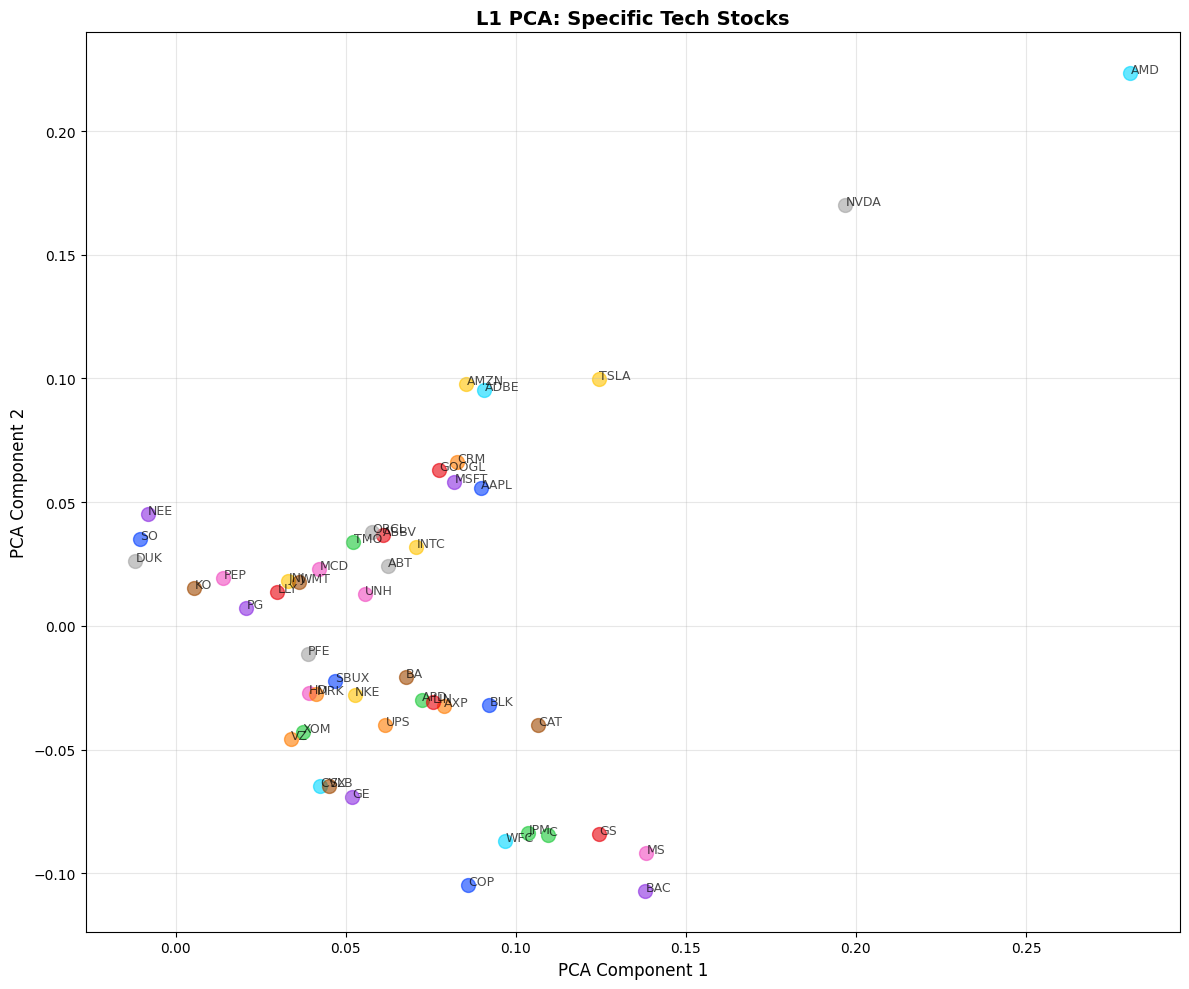

In [7]:
loader = StockDataLoader('data')

specific_tickers = ['GOOG', 'AAPL']
ticker_data = loader.load_data(tickers=DIVERSIFIED_50, date_range=('2017-01-01', '2018-01-01'))


log_return_vectors = calculate_log_returns(ticker_data)

pca_embeddings, ticker_labels = do_l1_pca(log_return_vectors, K=2)
print("PCA Embeddings shape:", pca_embeddings.shape)

# Visualize
create_scatterplot(pca_embeddings, ticker_labels, 
                    "L1 PCA: Specific Tech Stocks")
    


Stacked data shape: (49, 251)
QAPCA-R optimized b: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1]
Shapes: J: (49, 49), bbT: (49, 49), b_opt: (49,)
QAPCA-R optimized b: [-1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1 -1  1
 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1  1  1 -1
  1]
Shapes: J: (49, 49), bbT: (49, 49), b_opt: (49,)
Bopt shape: (49, 2)
X shape: (251, 49)
R_L1 shape: (251, 2)
PCA Embeddings shape: (2, 49)


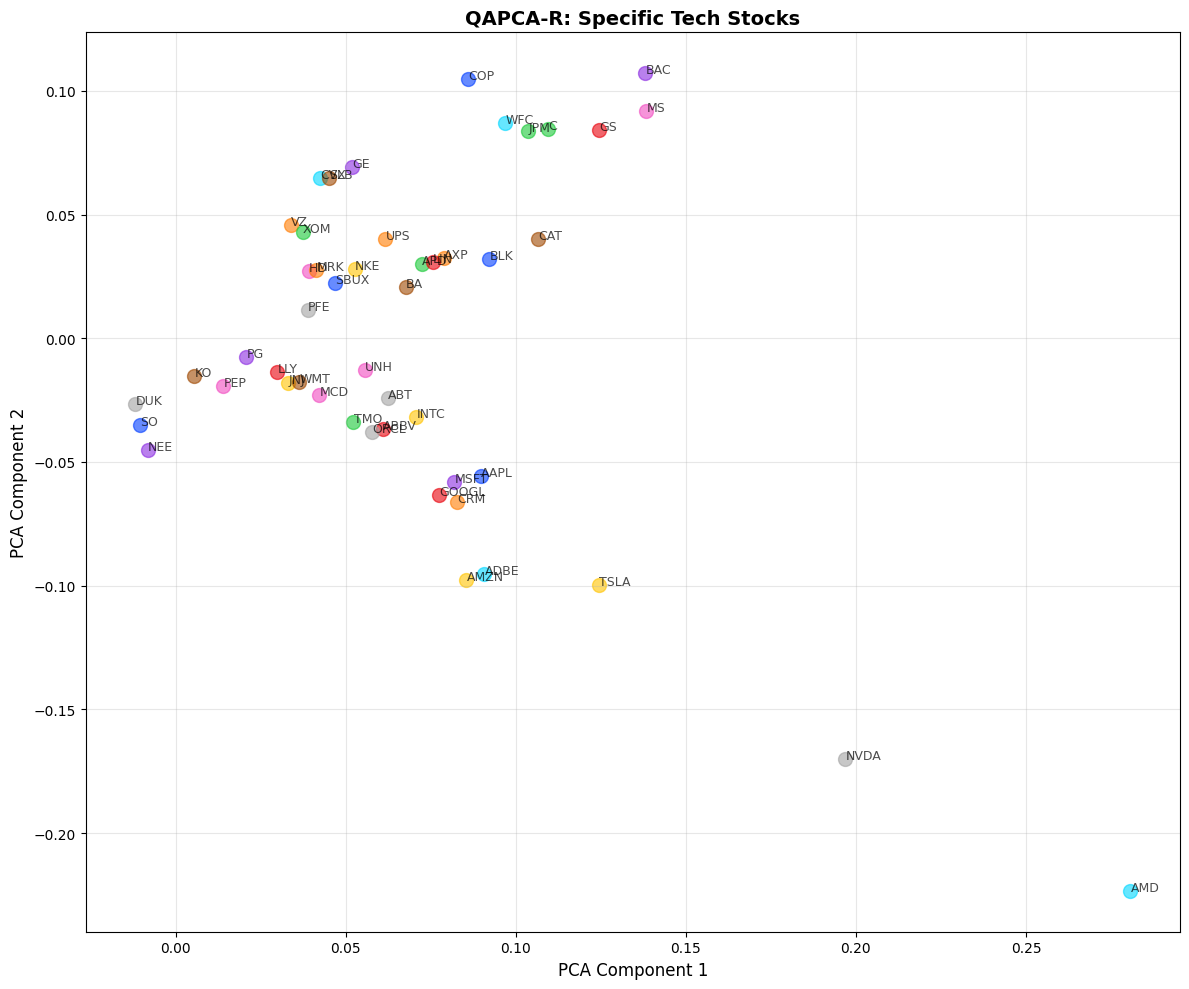

In [8]:

pca_embeddings, ticker_labels = do_l1_pca(log_return_vectors, K=2, get_component_func=solve_l1_qapca_r_component)
print("PCA Embeddings shape:", pca_embeddings.shape)

# Visualize
create_scatterplot(pca_embeddings, ticker_labels, 
                    "QAPCA-R: Specific Tech Stocks")
    

Stacked data shape: (49, 251)
Bopt shape: (49, 2)
X shape: (251, 49)
R_L1 shape: (251, 2)
PCA Embeddings shape: (2, 49)


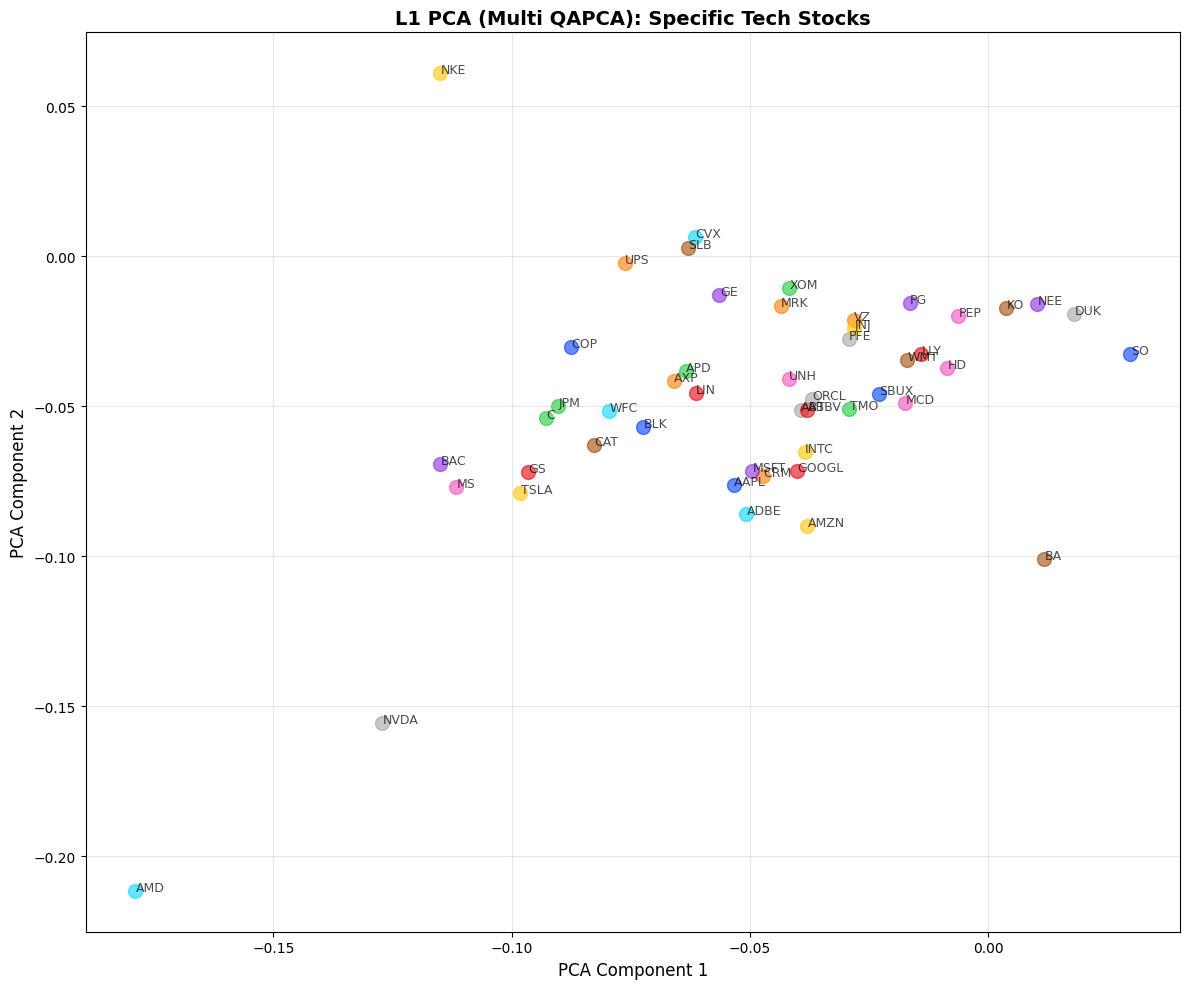

In [12]:

pca_embeddings, ticker_labels = do_l1_pca(log_return_vectors, K=2, get_component_func=solve_l1_multi_component, is_recursive=False)
print("PCA Embeddings shape:", pca_embeddings.shape)

# Visualize
create_scatterplot(pca_embeddings, ticker_labels, 
                    "L1 PCA (Multi QAPCA): Specific Tech Stocks")